# WALMART SALES PREDICTIONS

## EDA

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("Sources/Walmart_Store_sales.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
dataset.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [4]:
# Basic stats
data_desc = dataset.describe(include='all')
print("Shape", dataset.shape)
data_desc

Shape (150, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


150 rows, 8 columns.
Target variable : Y = 'Weekly_Sales'
First we remove the rows with missing target field (Weekly_Sales).

In [5]:
dataset.dropna(subset = ['Weekly_Sales'], inplace=True)
dataset.shape

(136, 8)

In [6]:
dataset.isna().sum()

Store            0
Date            18
Weekly_Sales     0
Holiday_Flag    11
Temperature     15
Fuel_Price      12
CPI             11
Unemployment    14
dtype: int64

There are missing values in every fields except 'Store' field. At first glance, 10% values are missing.

In [7]:
dataset.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896


### Store field study

In [8]:
np.sort(dataset.Store.unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

Stores are identified with number from 1 to 20.

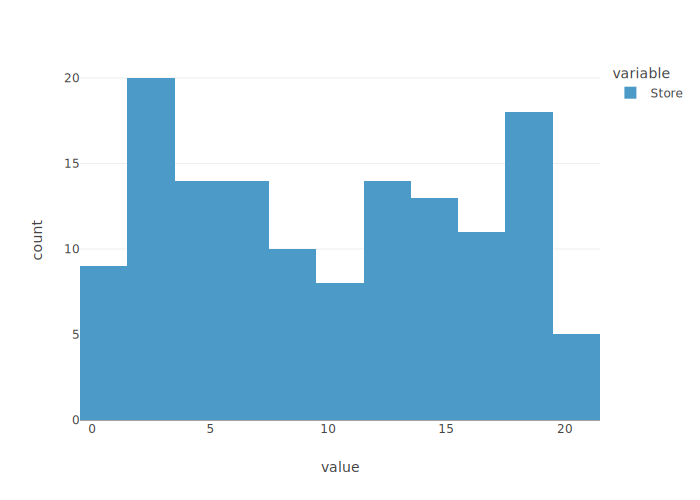

In [9]:
# Distribution of Store field
fig = px.histogram(dataset['Store'])
fig.show()

Store field can be used as feature as it is distributed without too low value counts.

### Holiday flag field study

In [10]:
dataset.Holiday_Flag.unique()

array([nan,  0.,  1.])

Some Holiday flags are not set. We could try to set if it is holiday or not with the help of Date field in US country.

In [11]:
missing_holiday = dataset[dataset['Holiday_Flag'].isna()]
missing_holiday

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
15,6.0,30-04-2010,1498080.16,NaN,68.91,2.780,211.894272,7.092
43,7.0,26-08-2011,629994.47,NaN,57.60,3.485,194.379637,8.622
48,1.0,05-08-2011,1624383.75,NaN,91.65,3.684,215.544618,7.962
53,14.0,25-03-2011,1879451.23,NaN,41.76,3.625,184.994368,8.549
65,10.0,NaN,1714309.90,NaN,43.43,3.287,127.191774,8.744
73,1.0,27-08-2010,1449142.92,NaN,85.22,2.619,211.567306,7.787
90,9.0,09-07-2010,485389.15,NaN,78.51,2.642,214.656430,6.442
118,9.0,18-06-2010,513073.87,NaN,82.99,2.637,215.016648,6.384
136,4.0,08-07-2011,2066541.86,NaN,84.59,3.469,129.112500,5.644


In [12]:
dates = pd.to_datetime(missing_holiday['Date'], dayfirst=True, errors = 'coerce')
min_dates = dates.min()
max_dates = dates.max()
print("Min date:", min_dates, " - Max date:", max_dates)

Min date: 2010-04-30 00:00:00  - Max date: 2011-08-26 00:00:00


Over the 11 rows, 9 are fed with the Date. We try to get holidays flag values from Date field, in US country.

In [13]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=min_dates, end=max_dates).to_pydatetime()
holidays

array([datetime.datetime(2010, 5, 31, 0, 0),
       datetime.datetime(2010, 7, 5, 0, 0),
       datetime.datetime(2010, 9, 6, 0, 0),
       datetime.datetime(2010, 10, 11, 0, 0),
       datetime.datetime(2010, 11, 11, 0, 0),
       datetime.datetime(2010, 11, 25, 0, 0),
       datetime.datetime(2010, 12, 24, 0, 0),
       datetime.datetime(2010, 12, 31, 0, 0),
       datetime.datetime(2011, 1, 17, 0, 0),
       datetime.datetime(2011, 2, 21, 0, 0),
       datetime.datetime(2011, 5, 30, 0, 0),
       datetime.datetime(2011, 7, 4, 0, 0)], dtype=object)

In [14]:
def fill_missing_holidays(row):
    # We fill the Holiday_Flag when is it nan value and Date is not null
    if np.isnan(row['Holiday_Flag']) and not pd.isnull(row['Date']):
        if pd.to_datetime(row['Date'], dayfirst=True, errors = 'coerce') in holidays:
            print(row['Date'], 'holiday')
            row['Holiday_Flag'] = 1
        else:
            print(row['Date'], 'not holiday')
            row['Holiday_Flag'] = 0
    return row

dataset = dataset.apply(lambda x : fill_missing_holidays(x), axis=1)

18-02-2011 not holiday
30-04-2010 not holiday
26-08-2011 not holiday
05-08-2011 not holiday
25-03-2011 not holiday
27-08-2010 not holiday
09-07-2010 not holiday
18-06-2010 not holiday
08-07-2011 not holiday


The missing Holidays Flags are considered as not holidays (0 value) as it is not in the US holidays calendar.

In [15]:
dataset

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,0.0,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


In [16]:
dataset[dataset['Holiday_Flag'].isna()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
65,10.0,NaN,1714309.90,NaN,43.43,3.287,127.191774,8.744
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN


We remove the lines with missing Holiday_Flag

In [17]:
dataset.dropna(subset=['Holiday_Flag'], inplace=True)
dataset.shape

(134, 8)

### Date field study

In [18]:
dataset[dataset['Date'].isna()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
9,3.0,NaN,418925.47,0.0,60.12,3.555,224.132020,6.833
17,18.0,NaN,1205307.50,0.0,21.33,2.788,131.527903,9.202
34,2.0,NaN,1853161.99,0.0,87.70,3.480,214.929625,NaN
42,1.0,NaN,1661767.33,1.0,NaN,3.730,222.439015,6.908
81,5.0,NaN,359206.21,0.0,NaN,3.630,221.434215,5.943
82,11.0,NaN,1569607.94,0.0,52.77,3.510,223.917015,6.833
83,15.0,NaN,607475.44,0.0,79.97,3.972,135.873839,7.806
86,17.0,NaN,986922.62,0.0,NaN,3.793,131.037548,6.235
88,20.0,NaN,2045837.55,0.0,39.79,3.739,213.472512,6.961


We remove lines without Date because we will exploit this data to predict sales.

In [19]:
dataset.dropna(subset=['Date'], inplace=True)
print("Shape", dataset.shape)
dataset.isna().sum()

Shape (118, 8)


Store            0
Date             0
Weekly_Sales     0
Holiday_Flag     0
Temperature     11
Fuel_Price      11
CPI              9
Unemployment    11
dtype: int64

Now, we add Year, Month, Day and Day_of_week fields to predict against those values

In [20]:
dataset['Day'] = dataset['Date'].str[:2].astype('int32')
dataset['Month'] = dataset['Date'].str[3:5].astype('int32')
dataset['Year'] = dataset['Date'].str[-4:].astype('int32')
dataset['Day_of_week'] = pd.to_datetime(dataset['Date'], dayfirst=True).dt.dayofweek
dataset
#pd.to_datetime(dataset['Date'], dayfirst=True, errors = 'coerce')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year,Day_of_week
0,6.0,18-02-2011,1572117.54,0.0,59.61,3.045,214.777523,6.858,18,2,2011,4
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470,25,3,2011,4
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092,28,5,2010,4
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896,28,5,2010,4
6,15.0,03-06-2011,695396.19,0.0,69.80,4.069,134.855161,7.658,3,6,2011,4
...,...,...,...,...,...,...,...,...,...,...,...,...
144,3.0,19-10-2012,424513.08,0.0,73.44,3.594,226.968844,6.034,19,10,2012,4
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899,18,6,2010,4
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN,11,6,2010,4
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN,12,8,2011,4


In [21]:
dataset['Day_of_week'].value_counts()

4    118
Name: Day_of_week, dtype: int64

Day of week is always the same (Friday). Therefore is adds no value at all, we remove it !
We remove Date field too !

In [22]:
dataset.drop(columns = ['Date', 'Day_of_week'], axis=1, inplace=True)
dataset

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Day,Month,Year
0,6.0,1572117.54,0.0,59.61,3.045,214.777523,6.858,18,2,2011
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,25,3,2011
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,28,5,2010
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,28,5,2010
6,15.0,695396.19,0.0,69.80,4.069,134.855161,7.658,3,6,2011
...,...,...,...,...,...,...,...,...,...,...
144,3.0,424513.08,0.0,73.44,3.594,226.968844,6.034,19,10,2012
145,14.0,2248645.59,0.0,72.62,2.780,182.442420,8.899,18,6,2010
147,17.0,845252.21,0.0,57.14,2.841,126.111903,NaN,11,6,2010
148,8.0,856796.10,0.0,86.05,3.638,219.007525,NaN,12,8,2011


### Temperature, Fuel_Price, CPI and Unemployment fields study

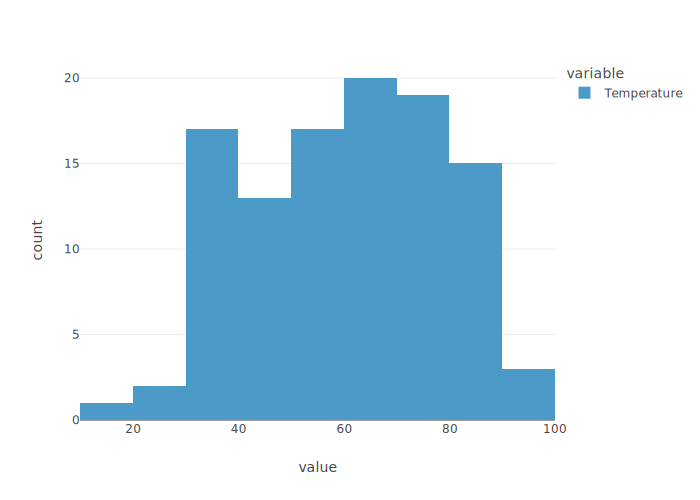

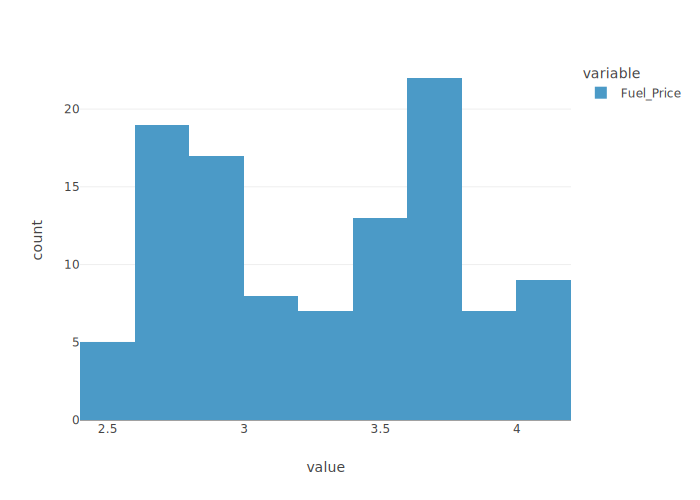

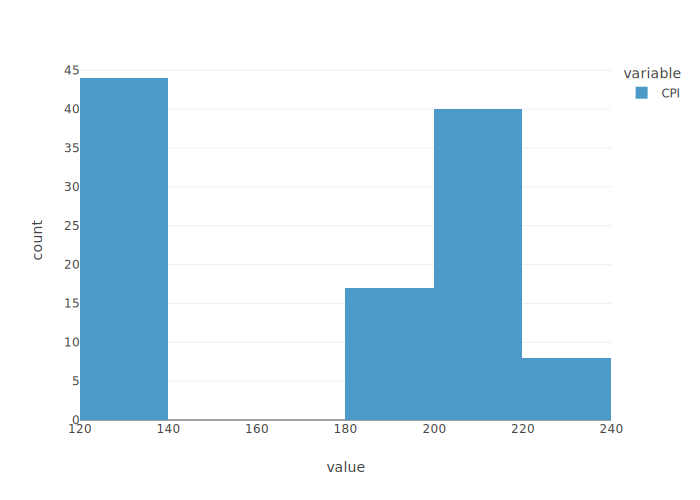

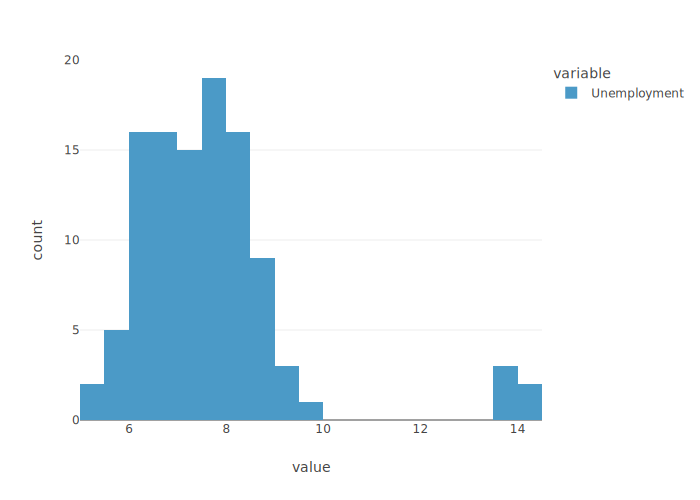

In [23]:
for field in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
    fig = px.histogram(dataset[field])
    fig.show()

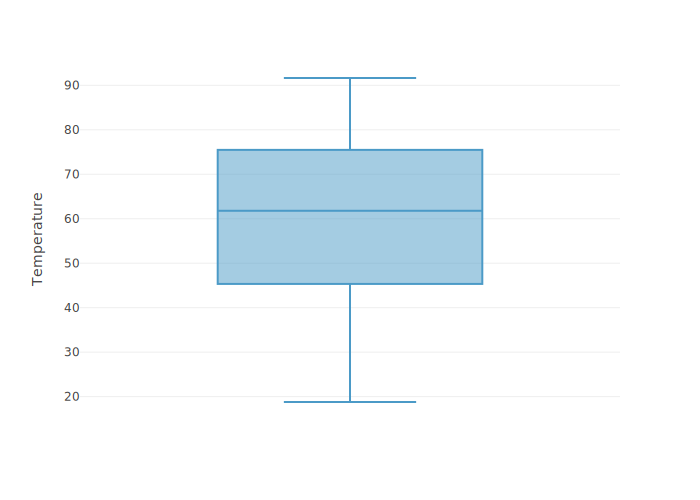

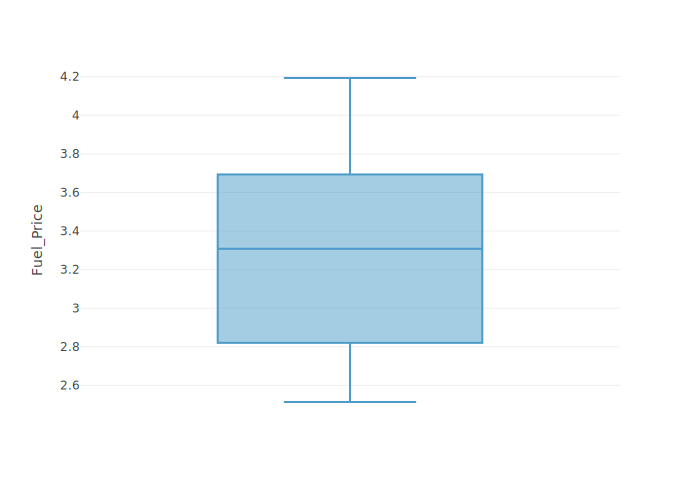

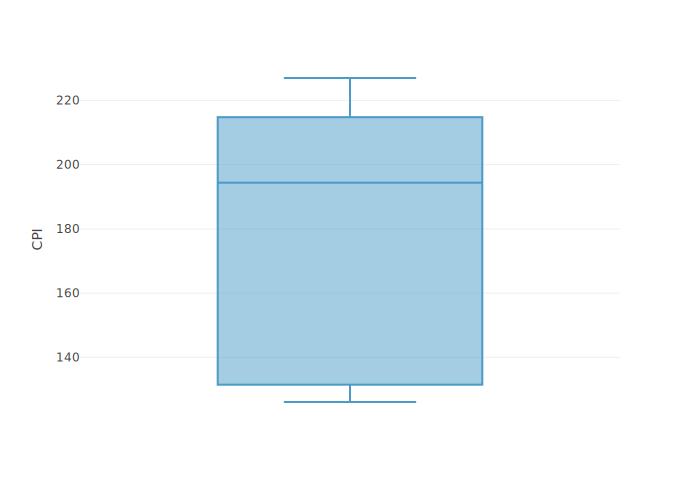

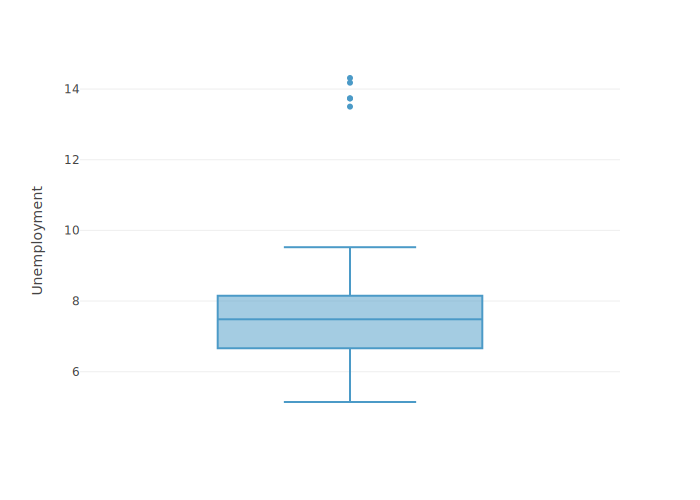

In [24]:
for field in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
    fig = px.box(dataset, y=field)
    fig.show()

There are outliers in Unemployment field. But we are going to remove the outliers for the 4 fields as indicated in the project : outside of [Xˉ−3σ,Xˉ+3σ]

In [25]:
for field in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
    std = dataset[field].std()
    mean = dataset[field].mean()
    dataset = dataset[(dataset[field].isna()) | ((dataset[field] < mean + 3*std) & (dataset[field] > mean - 3*std))]
    print(field, "std:", std, " - mean:", mean, " - range :[", mean - 3*std, ' - ',  mean + 3*std, ']')
print("Shape", dataset.shape)

Temperature std: 17.961675876213143  - mean: 60.71158878504672  - range :[ 6.826561156407294  -  114.59661641368615 ]
Fuel_Price std: 0.48678435193632946  - mean: 3.291542056074766  - range :[ 1.8311890002657776  -  4.751895111883754 ]
CPI std: 39.8166568947931  - mean: 177.7180085440367  - range :[ 58.26803785965741  -  297.167979228416 ]
Unemployment std: 1.678154670581751  - mean: 7.6812990654205615  - range :[ 2.646835053675309  -  12.715763077165814 ]
Shape (113, 10)


In [26]:
dataset.isna().sum()

Store            0
Weekly_Sales     0
Holiday_Flag     0
Temperature     10
Fuel_Price      11
CPI              9
Unemployment    11
Day              0
Month            0
Year             0
dtype: int64

There are still null values that will be calculated with Imputer during !

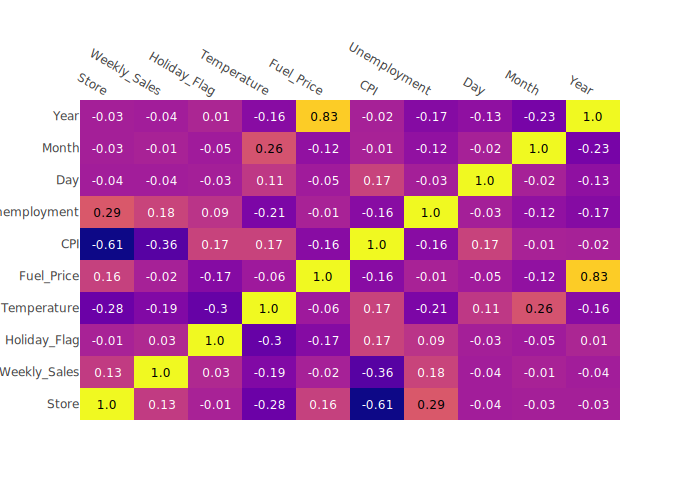

In [27]:
corr_matrix = dataset.corr().round(2)
import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())
fig.show()

We can see that features are not correlated with target (Weekly_Sales). Features are not correlated with each other too, except maybe CPI <-> Store.

## BASELINE MODEL - LINEAR REGRESSION

In [28]:
target = "Weekly_Sales"
X = dataset.drop(target, axis=1)
Y = dataset[target]

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

### Standardization

In [30]:
numeric_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Day']
categorical_features = ['Store', 'Holiday_Flag']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [31]:
print("Preprocessing X_train...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print("Names of the columns of preprocessed X data:", preprocessor.get_feature_names_out())
print(X_train[0:1]) 

Preprocessing X_train...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
52     9.0           0.0        85.02       2.653  214.896576           NaN   
11    18.0           0.0        52.02       2.878  132.763355         9.331   
105   19.0           0.0        72.83       2.932  132.598387         8.099   
110   20.0           1.0        28.85       3.179  204.643227         7.484   
75    20.0           0.0        75.17       2.808  204.567546         7.856   

     Day  Month  Year  
52    25      6  2010  
11    15     10  2010  
105   30      7  2010  
110   31     12  2010  
75    25      6  2010  
...Done.
Names of the columns of preprocessed X data: ['num__Temperature' 'num__Fuel_Price' 'num__CPI' 'num__Unemployment'
 'num__Year' 'num__Month' 'num__Day' 'cat__Store_2.0' 'cat__Store_3.0'
 'cat__Store_4.0' 'cat__Store_5.0' 'cat__Store_6.0' 'cat__Store_7.0'
 'cat__Store_8.0' 'cat__Store_9.0' 'cat__Store_10.0' 'cat__Store_11.0'
 'cat__Store_13.0' 'ca

In [32]:
print("Preprocessing X_test...")
print(X_test.head())
print()
X_test = preprocessor.transform(X_test)
print("...Done!")
print(X_test[0:1,:]) # X_test is now a numpy array
print() 

Preprocessing X_test...
     Store  Holiday_Flag  Temperature  Fuel_Price         CPI  Unemployment  \
141    5.0           0.0        62.37         NaN  212.560411         6.768   
13     1.0           0.0        64.74       3.734  221.211813         7.348   
29     6.0           0.0          NaN       3.523  217.270654         6.925   
10     8.0           0.0        82.92       3.554  219.070197         6.425   
144    3.0           0.0        73.44       3.594  226.968844         6.034   

     Day  Month  Year  
141   12     11  2010  
13    16      3  2012  
29    26      8  2011  
10    19      8  2011  
144   19     10  2012  

...Done!
[[ 1.93531073e-01 -9.67028174e-16  9.25274539e-01 -7.05317688e-01
  -1.05558715e+00  1.52508120e+00 -5.14580868e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00

### Training model

In [33]:
print("Train model with linear regression ...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model with linear regression ...
...Done.


In [34]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)

Predictions on training set...
...Done.
[ 355585.09124367 1159355.29938788 1403098.60982157 2066897.86334844
 1925751.39058183 1993378.09109697 2170861.80479594 1583913.14514438
  608309.47251647 2435430.82890442 1425012.44373189 2050457.39423482
 1963010.32321674 1988442.98996716 1292993.22892673 1895015.95229027
  577940.5575407  1356732.09545341 1370325.28797105  922168.7875471
 2118430.29683601  330062.81192987 1976468.41972023  363264.01495491
 1650427.27893564 1847044.77914    2037621.67177058 2047708.28745338
 2074840.9320166   683658.94625479  606434.1042874  1151700.92166614
  370649.67457154  403311.09748354 1538480.70206245 1983747.60606973
 2427756.87804595  429794.14134814 1620329.82185334 1560398.34734786
  507856.88236816  317368.86338655  403695.24855286 1491505.6134957
  756685.67597289  411578.63715934 1994109.78023765 2162634.00847892
 1757242.51        454895.21759604  944538.20767007 1480509.80572267
 2169009.6679558   138690.0555809  1399893.28404557  951527.42848

In [35]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)

Predictions on test set...
...Done.
[ 378501.12025534 1439255.57249924 1610241.58807788  882223.27111356
  466933.48815387 1108363.56016822 2062248.08061379 2316549.59407455
 2054918.82705112 1557403.30045123 1029671.02504803 2045617.7019931
 1120297.6495339   607686.47558959  466043.15125443   79356.42838598
  612205.50606513  168683.03779802 1810919.52958697  487763.60993983
 1924420.17546454  472644.73646539 2069806.24173904]


In [36]:
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9727237843593463
R2 score on test set :  0.9396190073986599


Predictions are very good but we can see some overfitting anyway.

In [37]:
regressor.coef_

array([  -31513.61547433,   -41295.66218524,   -95520.49388857,
         -71936.21160876,     4282.20729477,    74668.67929179,
         -37977.28662316,   355806.60652067, -1206228.15591785,
         279407.69552419, -1365747.32325047,    32640.44161767,
       -1000065.89835311,  -714341.47889698, -1172390.63116077,
         264167.76347575,   161876.19715782,   163524.64533844,
         546824.36642173, -1029657.52583133, -1154682.20563374,
       -1097046.09419354,  -601983.40020905,  -274981.85244811,
         402160.56031354,   -52738.11298168])

In [38]:
coefs = pd.DataFrame(index = preprocessor.get_feature_names_out(), data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
num__Temperature,-3.151362e+04
num__Fuel_Price,-4.129566e+04
num__CPI,-9.552049e+04
num__Unemployment,-7.193621e+04
num__Year,4.282207e+03
num__Month,7.466868e+04
num__Day,-3.797729e+04
cat__Store_2.0,3.558066e+05
cat__Store_3.0,-1.206228e+06
cat__Store_4.0,2.794077e+05


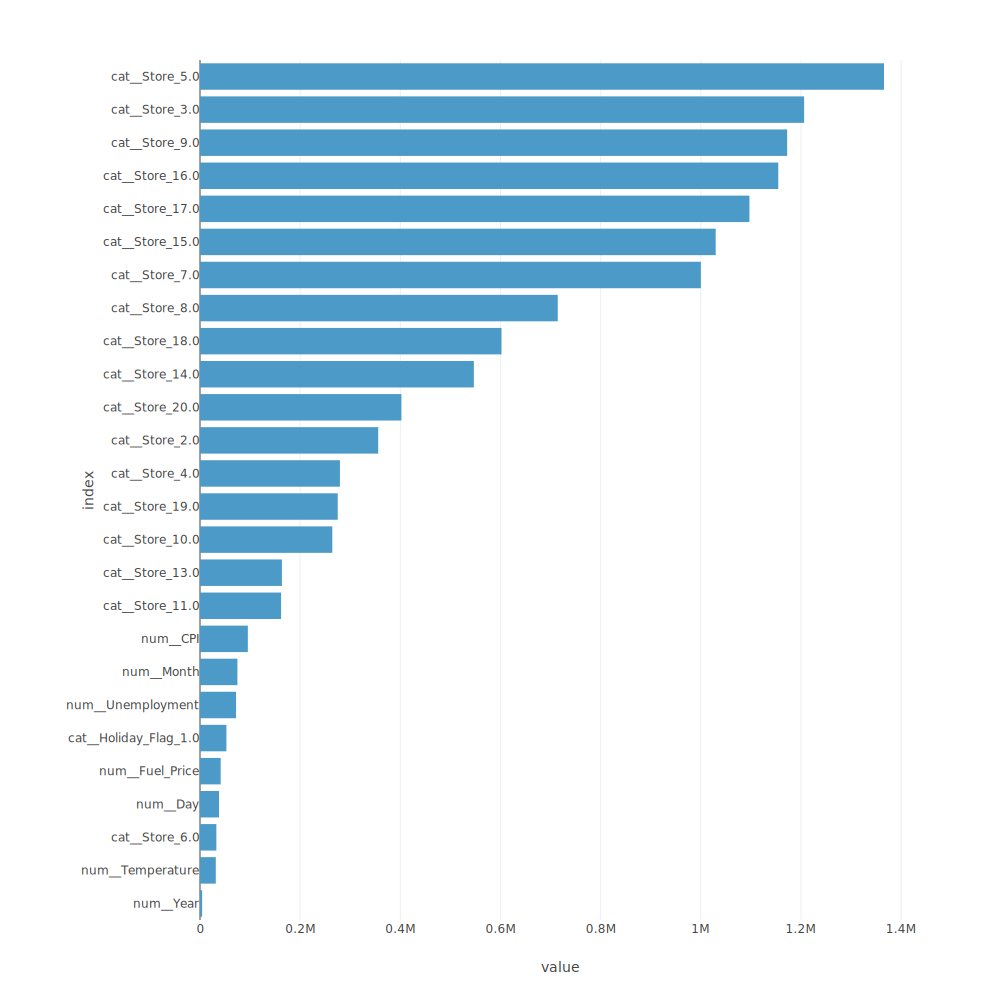

In [39]:
feature_importance = abs(coefs).sort_values(by = 'coefficients')
feature_importance
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, margin = {'l': 200}, width=1000, height=1000)
fig.show()

It seems that the Store field is crucial to predict the weekly sales !!!

## Fight overfitting : regularization

### Cross-validated score for a Ridge model (with default value of alpha)

In [40]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
print("3-fold cross-validation...")
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=3)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.7858947113578568
The standard deviation is :  0.035564227152254366


The R² score is worst than simple linear regression.
Let's try with 10 folds

In [41]:
print("10-fold cross-validation...")
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=10)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated R2-score is :  0.838396261820049
The standard deviation is :  0.05590331719058918


In [42]:
print("Let's try with 3 to 25 folds to get the best R² score")
regressor = Ridge()
score = 0
good_fold = None
for fold in range(3, 25):
    scores = cross_val_score(regressor, X_train, Y_train, cv=fold)
    if scores.mean() > score:
        score = scores.mean()
        std = scores.std()
        good_fold = fold

print('Best cross-validated R2-score is :', score, f'with {good_fold} folds')
print('The standard deviation is : ', std)

Let's try with 3 to 25 folds to get the best R² score
Best cross-validated R2-score is : 0.8465214622156141 with 9 folds
The standard deviation is :  0.04965238489493032


This is still worst than simple linear regresssion

### Grid search : tune alpha

In [43]:
from sklearn.model_selection import GridSearchCV
print("Grid search...")
regressor = Ridge()
# Grid of values to be tested
params = {'alpha': [0.0, 0.1, 0.5, 1.0]}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = good_fold)
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.9229775565390658


In [44]:
print("R2 score on training set : ", gridsearch.score(X_train, Y_train))
print("R2 score on test set : ", gridsearch.score(X_test, Y_test))

R2 score on training set :  0.9706524603355959
R2 score on test set :  0.951905472757692


### Let's try to fine tune the 'alpha' parameter

Ridge with alpha with 0.1 parameter is less overfitting than alpha with 0.05 which is better on training process but with ore overfitting.

# BONUS : ExtraTreesRegressor ! 👑

In [64]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, Y_train)
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  1.0
R2 score on test set :  0.9661779578762701


It is almost perfect ! 🥳

In [65]:
model.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}